In [80]:
import sys;sys.path.append('d:/code/pywfn')

In [81]:
from pywfn.base import Mole
from pywfn.reader import FchReader
from pywfn.gridprop import density
import numpy as np
import matplotlib.pyplot as plt
from pywfn.data.elements import elements
import pyvista as pv

In [82]:
mole=Mole(FchReader(rf"d:\gfile\pywfn\C6H6.fch"))
mole.xyzs

array([[-0.    ,  2.6483,  0.    ],
       [ 2.2935,  1.3241,  0.    ],
       [ 2.2935, -1.3241,  0.    ],
       [ 0.    , -2.6483,  0.    ],
       [-2.2935, -1.3241,  0.    ],
       [-2.2935,  1.3241,  0.    ],
       [-0.    ,  4.6703,  0.    ],
       [ 4.0446,  2.3351,  0.    ],
       [ 4.0446, -2.3351,  0.    ],
       [ 0.    , -4.6703,  0.    ],
       [-4.0446, -2.3351,  0.    ],
       [-4.0446,  2.3351,  0.    ]])

In [83]:
grids=[]
for x in np.linspace(-5,5,100):
    for y in np.linspace(-5,5,100):
        grids.append([x,y,0.5])
grids=np.array(grids)

In [84]:
caler=density.Calculator(mole)
mol_rho=np.array(caler.mol_rho(grids,0)[0])
pi_rho=np.array(caler.pi_rho(grids))

In [109]:
mat_mol=mol_rho.reshape(100,100)
mat_pi=pi_rho.reshape(100,100)
mat_rat=mat_pi/mat_mol

C:\Users\11032\AppData\Local\Temp\ipykernel_38848\2855768138.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


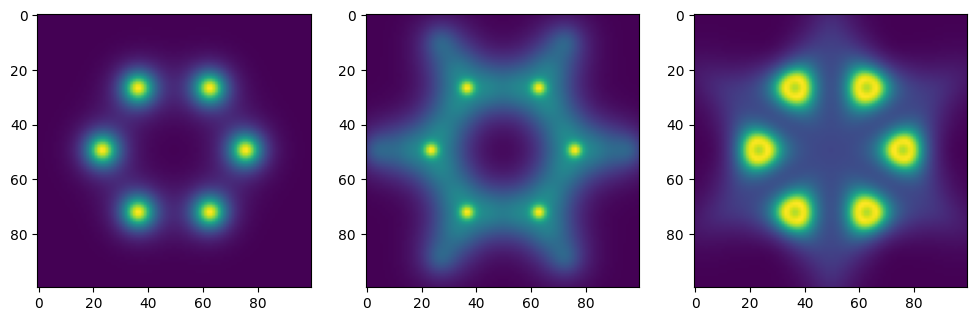

In [110]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(mat_pi)
axs[1].imshow(mat_mol)
axs[2].imshow(mat_rat)
fig.show()

In [103]:
# 自定义一些空间函数

def gauss_poten_vec(gx,gy,gz,coe)->np.ndarray: # 计算空间中一点的高斯势向量
    xyzs=mole.xyzs
    syms=mole.syms
    
    gau_vec=np.zeros(3)
    for i,xyz in enumerate(xyzs):
        sym=syms[i]
        R=elements[sym].rad
        vec=xyz-np.array([gx,gy,gz])
        dis=np.linalg.norm(vec)
        vec/=dis
        val=R*(np.exp(-coe*(dis-R)**2)+np.exp(-coe*dis**2))
        gau_vec+=val*vec
    return gau_vec

In [88]:
test_grids=np.random.rand(10,3)*10-5

In [ ]:
coes=[1.0]
vecs=[]
for gx,gy,gz in grids:
    vec=gauss_poten_vec(gx,gy,gz,1.0)
    mag=np.linalg.norm(vec)
    vecs.append(vec)

In [101]:
pl=pv.Plotter()
pl.add_points(grids)
pl.add_arrows(grids,np.array(vecs)*0.5)
pl.add_points(mole.xyzs)
pl.show()

Widget(value='<iframe src="http://localhost:12565/index.html?ui=P_0x203810f6560_17&reconnect=auto" class="pyvi…

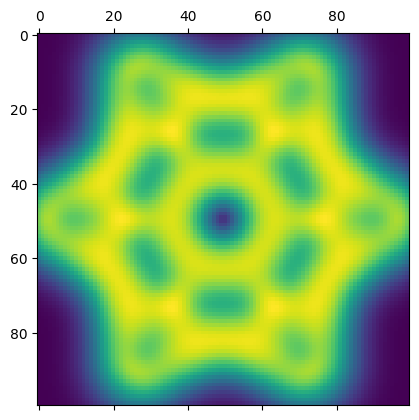

In [104]:
vals=[]
for x,y,z in grids:
    vec=gauss_poten_vec(x,y,z,1.1)
    vals.append(np.linalg.norm(vec))
mat_val=np.array(vals).reshape(100,100)
plt.matshow(mat_val)

In [107]:
def gauss_poten_val(gx,gy,gz,coe)->np.ndarray: # 计算空间中一点的高斯势向量
    xyzs=mole.xyzs
    syms=mole.syms
    
    gau_val=np.zeros(3)
    vecs=np.zeros_like(xyzs)
    for i,xyz in enumerate(xyzs):
        sym=syms[i]
        R=elements[sym].rad
        vec=xyz-np.array([gx,gy,gz])
        dis=np.linalg.norm(vec)
        if dis>1e-3:
            vec/=dis
        val_0=R*np.exp(-coe*(dis-R)**2) # 原子半径
        val_1=R*np.exp(-coe*dis**2) # 原子距离
        gau_val[0]+=val_0
        gau_val[1]+=val_1
        vecs[i]=vec
    gau_val[2]=np.linalg.norm(np.mean(vecs,axis=0))
    return gau_val

In [108]:
vals=[]
for x,y,z in grids:
    val=gauss_poten_val(x,y,z,1.0)
    vals.append(val)
vals=np.array(vals)
vals

array([[0.0036, 0.0002, 0.9215],
       [0.0054, 0.0003, 0.9201],
       [0.008 , 0.0004, 0.9187],
       ...,
       [0.008 , 0.0004, 0.9187],
       [0.0054, 0.0003, 0.9201],
       [0.0036, 0.0002, 0.9215]], shape=(10000, 3))

In [130]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


grids=np.random.rand(100000,3)*10-5
caler=density.Calculator(mole)
mol_rho=np.array(caler.mol_rho(grids,0)[0])
pi_rho=np.array(caler.pi_rho(grids))
vals=[]
for x,y,z in grids:
    val=gauss_poten_val(x,y,z,1.0)
    vals.append(val)
vals=np.array(vals)

model = XGBRegressor(n_estimators=500, max_depth=6, random_state=42)
X=vals
y=pi_rho#/mol_rho
model.fit(X,y)

y_pred = model.predict(vals)
print("MSE:", mean_squared_error(y, y_pred))


MSE: 4.963799951548776e-06


MSE: 0.0003110121718962896


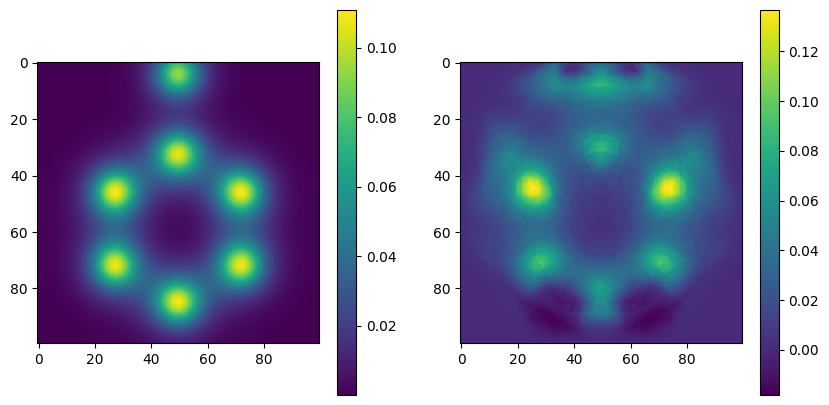

In [139]:
# 测试新的格点
grids=[]
for x in np.linspace(-5,5,100):
    for y in np.linspace(-5,5,100):
        grids.append([1.0,x,y])
grids=np.array(grids)
mole=Mole(FchReader(rf"d:\gfile\苯环电子数量变化\ph-CH3.fch"))
caler=density.Calculator(mole)
mol_rho=np.array(caler.mol_rho(grids,0)[0])
pi_rho=np.array(caler.pi_rho(grids))
vals=[]
for x,y,z in grids:
    val=gauss_poten_val(x,y,z,1.0)
    vals.append(val)
vals=np.array(vals)
y=pi_rho#/mol_rho
y_pred = model.predict(vals)
print("MSE:", mean_squared_error(y, y_pred))
fig,axs=plt.subplots(1,2,figsize=(10,5))
im1=axs[0].imshow(y.reshape(100,100))
im2=axs[1].imshow(y_pred.reshape(100,100))
plt.colorbar(im1,ax=axs[0])
plt.colorbar(im2,ax=axs[1])